In [1]:
!git clone https://github.com/makeyourownneuralnetwork/complex_valued_neuralnetwork.git

Cloning into 'complex_valued_neuralnetwork'...
remote: Enumerating objects: 81, done.
remote: Total 81 (delta 0), reused 0 (delta 0), pack-reused 81
Unpacking objects: 100% (81/81), done.


In [2]:
import tensorflow as tf
#import tensorflow_transform as tft
from sklearn.model_selection import train_test_split
import numpy as np
import pandas as pd

In [3]:
def get_data_iris_1D():
    df = pd.read_csv('complex_valued_neuralnetwork/iris_dataset/iris.csv')
    df[['PW', 'PL', 'SW', 'SL']] = df[['PW', 'PL', 'SW', 'SL']].astype(np.float64) * 0.01
    data = df.to_numpy()
    y = data[:,0]
    x = data[:,1:]
    #!rmdir /s complex_valued_neuralnetwork
    return train_test_split(x, y, train_size=0.75, stratify=y)

def get_data_mnist_1D():
    DATA_URL = 'https://storage.googleapis.com/tensorflow/tf-keras-datasets/mnist.npz'
    path = tf.keras.utils.get_file('mnist.npz', DATA_URL)
    with np.load(path) as data:
        train_examples = data['x_train']
        y_train = data['y_train'].astype(np.float64)
        test_examples = data['x_test']
        y_test = data['y_test'].astype(np.float64)
    dim2, dim3 = train_examples.shape[1], train_examples.shape[2]
    x_train = train_examples.reshape(train_examples.shape[0], dim2 * dim3)
    x_test = test_examples.reshape(test_examples.shape[0], dim2 * dim3)
    x_train = x_train.astype(np.float64)
    x_test = x_test.astype(np.float64)
    return x_train, x_test,  y_train, y_test

In [43]:
from abc import ABCMeta, abstractmethod, abstractproperty

class ComplexLayer():
    
    __metaclass__ = ABCMeta
    
    @abstractmethod
    def forward(self, cx):
        pass
    
    @abstractmethod
    def get_saved_outputs():
        pass
    
    @abstractmethod
    def get_outputs_num(self,):
        pass
    
    @abstractmethod
    def backward(self, inputs, upper_errors):
        pass        
        
class DenseHidden(ComplexLayer) :
    
    def __init__(self,  n_neurons = 32, learning_rate=1):
        self.n_neurons = n_neurons 
        self.learning_rate = tf.constant(learning_rate, dtype=tf.complex128) 
           
    def init_weigth(self, n_inputs = 32):
        self.n_inputs  = tf.constant(n_inputs+1, dtype=tf.complex128)
        self.weigth = tf.complex(
              tf.Variable(
                  tf.random.uniform([n_inputs+1, self.n_neurons], 
                                    minval=-6, 
                                    maxval=6, 
                                    dtype=tf.float64)),
              tf.Variable(
                  tf.random.uniform([n_inputs+1, self.n_neurons], 
                                    minval=-6, 
                                    maxval=6, 
                                    dtype=tf.float64))
        )
        
    #@tf.function
    def forward(self, inputs):         
        self.outputs = tf.matmul(inputs, self.weigth[1:,])
        # add bias
        self.outputs = tf.add(self.outputs, self.weigth[0,]) 
        # rescale back to the unit circle
        self.outputs = tf.math.divide(self.outputs, 
                                      tf.cast(
                                          tf.abs(self.outputs), tf.complex128
                                      )
                       )
        return self.outputs
        
    #@tf.function      
    def backward(self, inputs, upper_errors):
        # apply error sharing principle
        self.errors      = tf.math.divide(upper_errors, self.n_inputs)
        # apply self-adaptive learning rate
        self.errors      = tf.math.divide(self.errors, #
                                          tf.cast(
                                              tf.abs(self.outputs), tf.complex128
                                          )
                           ) 
        self.errors      = tf.math.multiply(self.errors, self.learning_rate)  
        # make error correction      
        # no neeed SELF for correction and projected_errors       
        self.correction       = tf.matmul(tf.transpose(tf.math.conj(inputs)), self.errors) 
        weigth_of_inputs = tf.add(self.weigth[1:,], self.correction) 
        weigth_of_bias = tf.add(self.weigth[0,], 
                                tf.math.reduce_sum( self.errors ))
        self.weigth = tf.concat([tf.expand_dims(weigth_of_bias, axis=0),
                                 weigth_of_inputs], 
                                axis = 0)
        # project errors to bottom layers
        self.projected_errors = self.project_errors_to_bottom()  
        return self.projected_errors
    
    def get_saved_outputs(self,):
        return self.outputs
    
    def get_outputs_num(self,):
        return self.n_neurons
        
    #@tf.function
    def project_errors_to_bottom(self):
        inverted         = tf.math.conj(self.weigth[1:,:]) 
        factor           = tf.math.square(tf.abs(self.weigth[1:,:])) 
        inverted_scaled  = tf.math.divide(inverted, 
                                          tf.cast(
                                              tf.abs(factor), tf.complex128
                                          )
                           )
        projected_errors = tf.matmul(self.errors, tf.transpose(inverted_scaled))
        return projected_errors

class DenseLast(DenseHidden) :
        
    #@tf.function
    def backward(self, inputs, desired_outputs):
        # output layer error is the (target - actual)
        self.errors   = tf.math.subtract(desired_outputs, self.outputs) 
        # error sharing principle
        self.errors   = tf.math.divide(self.errors, self.n_inputs)
        self.errors   = tf.math.multiply(self.errors, self.learning_rate)
        
        
        # error correction
        # no neeed SELF for correction and projected_errors 
        self.correction       = tf.matmul(tf.transpose(tf.math.conj(inputs)), self.errors) 
        weigth_of_inputs = tf.add(self.weigth[1:,], self.correction) 
        weigth_of_bias   = tf.add(self.weigth[0,], 
                                tf.math.reduce_sum(self.errors))
        self.weigth = tf.concat([tf.expand_dims(weigth_of_bias, axis=0),
                                 weigth_of_inputs], 
                                 axis = 0)
        # project errors to bottom layer
        self.projected_errors = self.project_errors_to_bottom()  
        return self.projected_errors
        
class InputConverter(ComplexLayer) :
    
    def __init__(self, n_inputs=1, mapping_gap = 0.01):
        self.mapping_gap = tf.constant(mapping_gap, dtype=tf.float64 ) 
        self.const_2pi = tf.constant(2*np.pi, dtype=tf.float64)
        self.n_inputs = n_inputs
            
    #@tf.function
    def forward(self, inputs):
        inputs = tf.cond(
            tf.math.greater(tf.rank(inputs), tf.constant(1)),
            lambda: inputs, 
            lambda: tf.expand_dims(inputs, axis=0)
        )
        inputs_modified = tf.math.multiply(inputs, self.const_2pi )
        inputs_modified = tf.math.subtract(inputs_modified, self.mapping_gap)
        inputs_modified_real = tf.math.cos(inputs_modified)
        inputs_modified_imag = tf.math.sin(inputs_modified)
        self.outputs = tf.complex(inputs_modified_real, inputs_modified_imag)
        return self.outputs
 
    #@tf.function
    def backward(self, inputs):
        pass
    
    def get_outputs_num(self,):
        return self.n_inputs
    
    #@tf.function
    def get_saved_outputs(self,):
        return self.outputs

class OutputDiscreteConverter(ComplexLayer):
    
    def __init__(self, categories_num=3, periods_num=3):
        self.categories_num = categories_num
        self.periods_num    = periods_num
        self.const_2pi = tf.constant(2*np.pi, dtype=tf.float64)
        
    #@tf.function
    def forward(self, inputs):
        # first work out the angle, but shift angle from [-pi/2, +pi.2] to [0,2pi]
        # angle = np.mod(np.angle(z) + 2*np.pi, 2*np.pi)
        angle = tf.math.floormod(
                    tf.math.add(
                        tf.math.angle(inputs),
                        self.const_2pi
                    ),
                    self.const_2pi)
        # from angle to category
        # p = np.floor (self.categories * self.periodicity * angle / (2*np.pi))
        self.outputs = tf.math.floor(
            tf.math.divide(
                tf.math.multiply(
                    angle,
                    tf.constant(self.categories_num*self.periods_num, dtype=tf.float64)
                ),
                self.const_2pi
            )
        )
        return self.outputs

    #@tf.function
    def get_saved_outputs(self,):
        return self.outputs
    
    def get_outputs_num(self,):
        return 1
    
    #@tf.function
    def backward(self, desired_outputs):
        targets = tf.cond(
            tf.math.greater(tf.rank(desired_outputs), tf.constant(0, dtype=tf.int32)),
            lambda: desired_outputs, 
            lambda: tf.expand_dims(desired_outputs, axis=0)
        )
        # class to angle, using bisector
        targets_angle = tf.math.multiply(
            tf.math.divide(
                tf.math.add(targets, tf.constant(0.5, dtype=tf.float64)),
                tf.constant(self.categories_num*self.periods_num, dtype=tf.float64)
            ),
            tf.constant(2*np.pi, dtype=tf.float64)
        )
        # map target classes to unit circle
        targets_modified_real = tf.math.cos(targets_angle)
        targets_modified_imag = tf.math.sin(targets_angle)
        targets_modified_v2 = tf.complex(targets_modified_real, targets_modified_imag)
        targets_modified_v2 = tf.expand_dims(targets_modified_v2, axis=1)
        return targets_modified_v2
    
class OutputECOCConverter(OutputDiscreteConverter):
    def __init__(self, categories_num=3, periods_num=3):
        pass

    #@tf.function
    def forward(self, inputs):
        pass

    #@tf.function
    def get_saved_outputs(self,):
        return self.outputs
    
    def get_outputs_num(self,):
        return 1
    
    #@tf.function
    def backward(self, desired_outputs):
        pass
    
class ComplexNetwork:
    
    def __init__(self, layers=None):
        self.layers = layers
        for i in range(1, len(self.layers)-1):
            i_num = self.layers[i-1].get_outputs_num()
            self.layers[i].init_weigth(n_inputs = i_num)
       
    #@tf.function
    def inference(self, inputs):
        out = inputs
        for layer in self.layers:
            out = layer.forward(out)
        return out
    
    #@tf.function
    def __backprop(self, x_mbatch, y_mbatch):
        layer_supervision = self.layers[-1].backward(y_mbatch)
        #print(layer_supervision)
        num_layers_without_target_encoder = len(self.layers)-1
        for i in range(num_layers_without_target_encoder-1, 0, -1):
            #print("layer = ", i)
            layer_inputs = self.layers[i-1].get_saved_outputs()
            #print("layer "+str(i)+" inputs = ", layer_inputs)
            layer_supervision = self.layers[i].backward(layer_inputs, layer_supervision)
    
    #@tf.function
    def train(self, x_mbatch, y_mbatch):
        self.inference(x_mbatch)
        self.__backprop(x_mbatch, y_mbatch)

max_test_acc =  0.631578947368421
max_train_acc =  0.8125


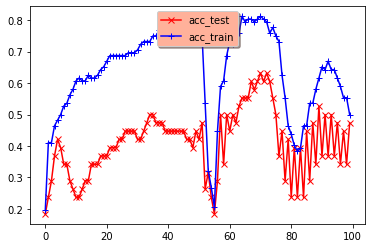

In [74]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt

x_train, x_test, y_train, y_test = get_data_iris_1D()
#x_train, x_test, y_train, y_test = get_data_mnist_1D()
scaler = MinMaxScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.fit_transform(x_test)
    
# categories, periodicity
class_num = np.unique(y_train).size 
periods = 6
lr=1
           
net = ComplexNetwork(layers=[
               InputConverter(n_inputs =4), 
               DenseHidden(     n_neurons=15, learning_rate=lr), 
               DenseHidden(     n_neurons=15, learning_rate=lr), 
               DenseLast(       n_neurons=1,    learning_rate=lr), 
               OutputDiscreteConverter(categories_num=class_num, periods_num=periods)
                            ])
      

# train neural network 
max_epochs = 100
acc_test = []
acc_train = []
batch_size = y_train.shape[0]

for e in range(max_epochs):
    for i in range( int(y_train.shape[0]/batch_size)):
        inputs = x_train[i*batch_size:(i+1)*batch_size] 
        targets = y_train[i*batch_size:(i+1)*batch_size] 
        
        net.train(tf.convert_to_tensor(inputs), 
                  tf.convert_to_tensor(targets))  
    
    y_pred_test = net.inference( tf.convert_to_tensor(x_test) ).numpy().T[0]
    y_pred_train = net.inference( tf.convert_to_tensor(x_train) ).numpy().T[0]
       
    acc_test.append( accuracy_score(y_test, y_pred_test) )
    acc_train.append( accuracy_score(y_train, y_pred_train) )
    #print("acc_train=",acc_train[-1], ", acc_test=", acc_test[-1])

print("max_test_acc = ", max(acc_test))
print("max_train_acc = ", max(acc_train))
plt.ioff()
fig, ax = plt.subplots()
x_arr = np.array(list(range(len(acc_test))))
y_arr1 = np.array(acc_test)
y_arr2 = np.array(acc_train)

ax.plot(x_arr, y_arr1, 'rx', x_arr, y_arr2, 'b+', linestyle='solid')
lgnd = ax.legend(['acc_test', 'acc_train'], loc='upper center', shadow=True)
lgnd.get_frame().set_facecolor('#ffb19a')

plt.show()

In [20]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt

x_train, x_test, y_train, y_test = get_data_iris_1D()
#x_train, x_test, y_train, y_test = get_data_mnist_1D()
scaler = MinMaxScaler()
x_train = scaler.fit_transform(x_train)#[0:1000]
#y_train = y_train[0:1000]
x_test = scaler.fit_transform(x_test)

# number of input, hidden and output nodes
input_nodes = x_train.shape[1] 
hidden_nodes1 = 200
hidden_nodes2 = 200
output_nodes = 1

# categories, periodicity
categories = np.unique(y_train).size 
print("categories_num = ", categories)
print("features_num = ", len(x_test[0]))
periodicity = 6

# create instance of neural network
n = neuralNetwork2(input_nodes, 
                   hidden_nodes1, 
                   hidden_nodes2,  
                   output_nodes, 
                   categories, 
                   periodicity, 
                   learning_rate = 0.1)

categories_num =  3
features_num =  4
self.wih1.shape =  (5, 200)
self.wih2.shape =  (201, 200)
self.who.shape =  (201, 1)


max_test_acc =  0.2631578947368421
max_train_acc =  0.4375


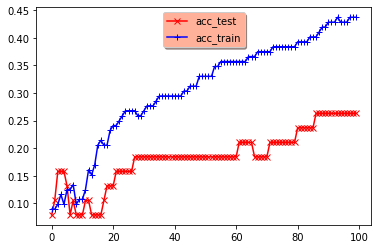

In [21]:
# train neural network 
max_epochs = 100
acc_test = []
acc_train = []
batch_size = y_train.shape[0]
for e in range(max_epochs):
    for i in range( int(y_train.shape[0]/batch_size)):
        inputs = x_train[i*batch_size:(i+1)*batch_size] 
        targets = y_train[i*batch_size:(i+1)*batch_size]  
        n.train(inputs, targets)
        
    y_pred_test = n.inference(x_test)  
    y_pred_train = n.inference(x_train)
    
    acc_test.append( accuracy_score(y_test, y_pred_test) )
    acc_train.append( accuracy_score(y_train, y_pred_train) )

print("max_test_acc = ", max(acc_test))
print("max_train_acc = ", max(acc_train))
plt.ioff()
fig, ax = plt.subplots()
x_arr = np.array(list(range(len(acc_test))))
y_arr1 = np.array(acc_test)
y_arr2 = np.array(acc_train)

ax.plot(x_arr, y_arr1, 'rx', x_arr, y_arr2, 'b+', linestyle='solid')
 
lgnd = ax.legend(['acc_test', 'acc_train'], loc='upper center', shadow=True)
lgnd.get_frame().set_facecolor('#ffb19a')

plt.show()
